In [45]:
#import library
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse



from scipy.special import expit
# import csv
# import copy
# import itertools
# from lightfm import LightFM
# import lightfm.evaluation

# import helper_functions

In [46]:
# data folder path
PATH_TO_DATA = 'data/'

In [47]:
# read csv files
# dec_df = pd.read_csv(PATH_TO_DATA + '2019-Dec.csv')
nov_df = pd.read_csv(PATH_TO_DATA + '2019-Nov.csv')
oct_df = pd.read_csv(PATH_TO_DATA + '2019-Oct.csv')

In [48]:
# filtering purchase data only 
# dec_df = dec_df.loc[dec_df['event_type'] != 'purchase']
nov_df = nov_df.loc[nov_df['event_type'] == 'purchase']
oct_df = oct_df.loc[oct_df['event_type'] == 'purchase']

In [49]:
# shape of data
print("oct data shape", oct_df.shape)
print("nov data shape", nov_df.shape)
# print("dec data shape", dec_df.shape)

oct data shape (742849, 9)
nov data shape (322417, 9)


In [50]:
# concate 2 month data
Final_data = pd.concat([oct_df, nov_df], ignore_index=True)
Final_data.shape

(1065266, 9)

## RFMV Analysis

In [52]:
## standardize transaction date into pandas datetime index
Final_data['Date'] = pd.DatetimeIndex(Final_data['event_time'], dayfirst=True).date

In [53]:
import datetime as dt

now = dt.date(2020, 1, 1) # just take the max date from the index + 1
print(now)

2020-01-01


In [54]:
def rfmv_analysis(Final_data, now):
    # calculating RECENCY
    recency_df = Final_data.groupby('user_id').Date.max().reset_index()
    recency_df.columns = ['user_id','Last Purchase']
    recency_df['Recency'] = recency_df['Last Purchase'].apply(lambda x: (now - x).days)
    recency_df = recency_df[['user_id', 'Recency']]
    
    # calculating FREQUENCY
    frequency_df = Final_data.groupby('user_id')['Date'].count().reset_index()
    frequency_df.columns = ['user_id','Frequency']
    
    # monitory
    Monitory_data = Final_data.groupby(['user_id', 'product_id', 'price']).agg({'product_id': 'count'}).rename(columns={'product_id': 'purchase_count'}).reset_index().sort_values(by='user_id')
    Monitory_data = Monitory_data.drop_duplicates(subset=['product_id', 'user_id', 'purchase_count', 'price'])
    ### calculate total net sales from quantity and based price (minus Tax, as it may be different from city to city)
    Monitory_data['Net Sales'] = Monitory_data['purchase_count'] * Monitory_data['price']
    monetary_df = Monitory_data.groupby('user_id')['Net Sales'].sum().reset_index()
    monetary_df.columns = ['user_id','Monetary']
    
    # calculating VARIETY 
    variety_df = Monitory_data.groupby('user_id')['product_id'].nunique().reset_index()
    variety_df.columns = ['user_id','Variety']
    rfmv = recency_df.copy()

    rfmv = rfmv.merge(frequency_df, on='user_id')
    rfmv = rfmv.merge(monetary_df, on='user_id')
    rfmv = rfmv.merge(variety_df, on='user_id')
    
    return rfmv
    

In [55]:
rfmv = rfmv_analysis(Final_data, now)

In [56]:
rfmv.head()

,user_id,Recency,Frequency,Monetary,Variety
0,9794320,37,4,12.68,4
1,10079204,204,2,25.81,2
2,10280338,41,16,54.83,15
3,15781728,46,2,20.31,2
4,19762782,82,8,80.29,8


In [57]:
### we take the 25%, 50%, and 75% quantile for each of R, F, M, and V and store them into dictionary data type
rfmv_quantiles = rfmv.iloc[:, 1:].quantile(q = [0.25, 0.5, 0.75]).to_dict()
rfmv_quantiles

{'Recency': {0.25: 64.0, 0.5: 72.0, 0.75: 80.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 79.66, 0.5: 213.06, 0.75: 540.27},
 'Variety': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0}}

In [58]:
## create a function that returns a score--0 to 4 based on the quartile ranking
## these score can be easily interpreted by the K-Mean algorithm instead of the actual value of RFMB

### recency score: the lower the recency, the higher the score 
def RecencyScore(i, col, df):
    if i <= df[col][0.25]:
        return 4
    elif i <= df[col][0.50]:
        return 3
    elif i <= df[col][0.75]: 
        return 2
    else:
        return 1
    
# F, M, V: In contrast to Recency, the higher the quantile value, the higher the score    
def FMVScore(i, col, df):
    if i <= df[col][0.25]:
        return 1
    elif i <= df[col][0.50]:
        return 2
    elif i <= df[col][0.75]: 
        return 3    
    else:
        return 4

In [59]:
rfmv2 = rfmv.copy()

rfmv2['R_q'] = rfmv2['Recency'].apply(RecencyScore, args=('Recency', rfmv_quantiles ))
rfmv2['F_q'] = rfmv2['Frequency'].apply(FMVScore, args=('Frequency', rfmv_quantiles ))
rfmv2['M_q'] = rfmv2['Monetary'].apply(FMVScore, args=('Monetary', rfmv_quantiles ))
rfmv2['V_q'] = rfmv2['Variety'].apply(FMVScore, args=('Variety', rfmv_quantiles ))

rfmv2 = rfmv2[['user_id', 'R_q', 'F_q', 'M_q', 'V_q',]]

# # Sum total scores of each component

rfmv2['Total_Score'] = rfmv2['R_q'] + rfmv2['F_q'] + rfmv2['M_q'] + rfmv2['V_q']

rfmv2 = rfmv2[['user_id', 'Total_Score']]

# IMPORTANT: set index to customer number
rfmv2.index = rfmv2['user_id']
rfmv2 = rfmv2.drop('user_id', 1)

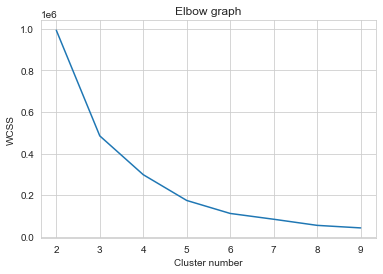

In [60]:
# We use elbow method to find the optimal number of clusters

wcss = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++')
    kmeans.fit(rfmv2)
    wcss.append(kmeans.inertia_)
    
# Plot the graph for Elbow Method
plt.plot(range(2,10), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()


In [61]:
# Apply KMean clustering using the optimal number with the "elbow" on the graph above
kmeans = KMeans(n_clusters=4, 
                init='random', 
                random_state=None)

clusters = kmeans.fit_predict(rfmv2)

### add the cluster result to the original rfmv dataframe
rfmv['Clusters'] = clusters

In [62]:
rfmv.head(5)

,user_id,Recency,Frequency,Monetary,Variety,Clusters
0,9794320,37,4,12.68,4,3
1,10079204,204,2,25.81,2,0
2,10280338,41,16,54.83,15,3
3,15781728,46,2,20.31,2,2
4,19762782,82,8,80.29,8,2


In [63]:
### counter is a nice function to see how many counts belong to each unique value
### in this case we want to know how may members allocated in each cluster

Counter(clusters)

Counter({3: 83426, 0: 120881, 2: 64179, 1: 110156})

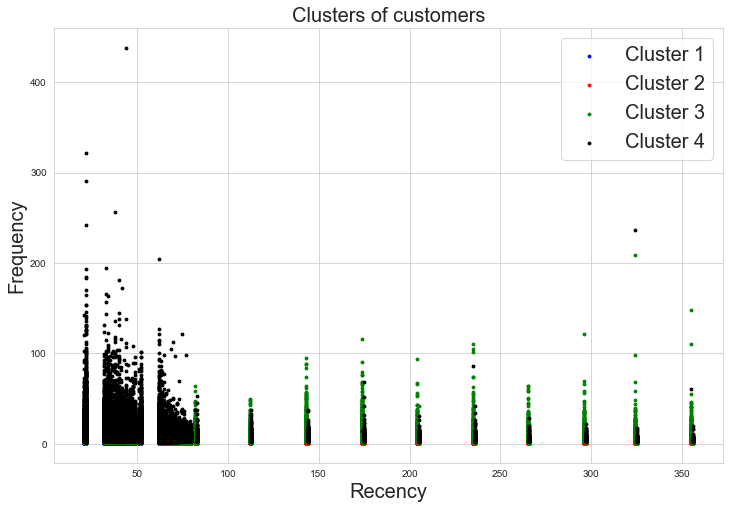

In [64]:
## optional: plot the two components with their respective RFMV to see the shape of the clusters
## optional: you can try to plot other RFMV components too

fig, ax = plt.subplots(figsize=(12,8))

var1 = 'Recency'
var2 = 'Frequency'
temp = rfmv.copy()

c1 = temp[temp.Clusters == 0]
c2 = temp[temp.Clusters == 1]
c3 = temp[temp.Clusters == 2]
c4 = temp[temp.Clusters == 3]

# Visualization of the clusters
plt.scatter(c1[var1], c1[var2], c = 'b', label = 'Cluster 1', s=8)
plt.scatter(c2[var1], c2[var2], c = 'r', label = 'Cluster 2', s=8)
plt.scatter(c3[var1], c3[var2], c = 'g', label = 'Cluster 3', s=8)
plt.scatter(c4[var1], c4[var2], c = 'k', label = 'Cluster 4', s=8)

plt.title('Clusters of customers', size=20)
plt.xlabel(var1, size=20)
plt.ylabel(var2, size=20)
plt.legend(fontsize=20)

In [65]:
temp

,user_id,Recency,Frequency,Monetary,Variety,Clusters
0,9794320,37,4,12.68,4,3
1,10079204,204,2,25.81,2,0
2,10280338,41,16,54.83,15,3
3,15781728,46,2,20.31,2,2
4,19762782,82,8,80.29,8,2
...,...,...,...,...,...,...
378637,579906406,32,2,9.68,2,2
378638,579916096,32,4,9.42,4,3
378639,579924768,32,3,8.54,3,3
378640,579925377,32,6,38.23,6,3
